Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


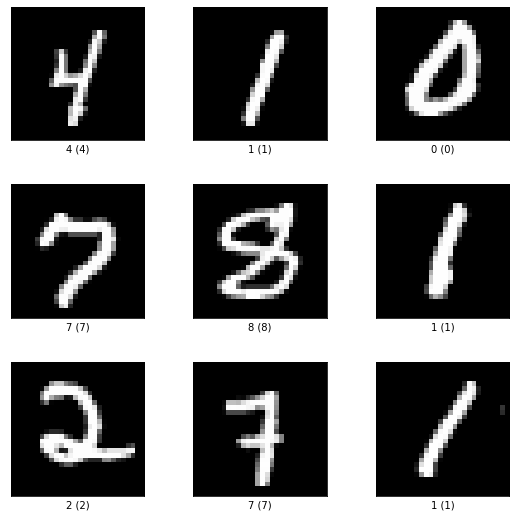

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load("mnist", split="train", with_info=True)
fig = tfds.show_examples(mnist, info)

(28, 28, 1)


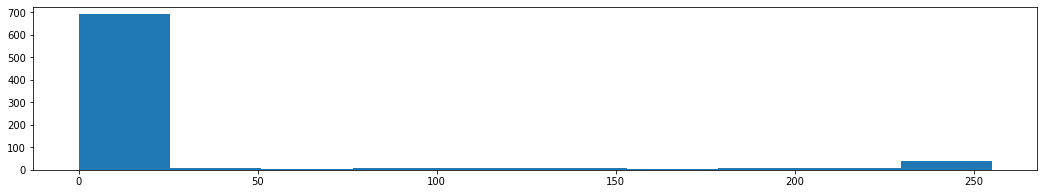

In [2]:
for data in mnist:
    print(data['image'].shape)
    break

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=[18, 3])
plt.hist(tf.reshape(data['image'], -1).numpy(), bins=10)
plt.show()

In [3]:
tf.one_hot(data['label'], 10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)>

In [4]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


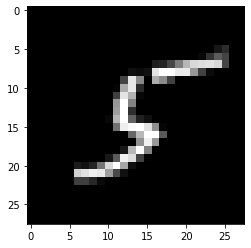

In [5]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

In [6]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


In [7]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


In [8]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


In [9]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅
✅


In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


In [11]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [12]:
EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 100 ITER] G:2.421293020248413, D:0.1109018474817276
[1/1 EPOCHS, 200 ITER] G:2.2202277183532715, D:0.14372391998767853
[1/1 EPOCHS, 300 ITER] G:2.568895101547241, D:0.11959761381149292
[1/1 EPOCHS, 400 ITER] G:2.3609251976013184, D:0.15266413986682892


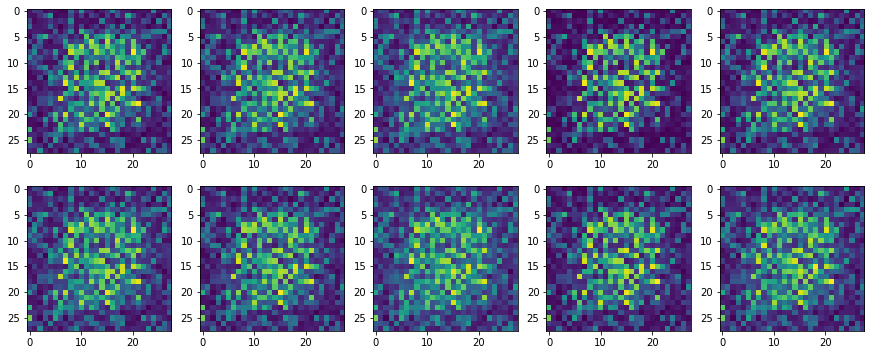

In [13]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [21]:
!mkdir -p ~/aiffel/conditional_generation/gan

In [22]:
!wget https://d3s0tskafalll9.cloudfront.net/media/documents/GAN_500.zip

--2021-10-18 13:47:09--  https://d3s0tskafalll9.cloudfront.net/media/documents/GAN_500.zip
Resolving d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)... 13.227.62.106, 13.227.62.109, 13.227.62.14, ...
Connecting to d3s0tskafalll9.cloudfront.net (d3s0tskafalll9.cloudfront.net)|13.227.62.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2151851 (2.1M) [application/zip]
Saving to: ‘GAN_500.zip’

GAN_500.zip         100%[===================>]   2.05M  --.-KB/s    in 0.02s   

2021-10-18 13:47:09 (120 MB/s) - ‘GAN_500.zip’ saved [2151851/2151851]



In [23]:
!mv GAN_500.zip ~/aiffel/conditional_generation/gan

In [24]:
!cd ~/aiffel/conditional_generation/gan && unzip GAN_500.zip

Archive:  GAN_500.zip
  inflating: GAN_500.index           
  inflating: GAN_500.data-00001-of-00002  
  inflating: GAN_500.data-00000-of-00002  


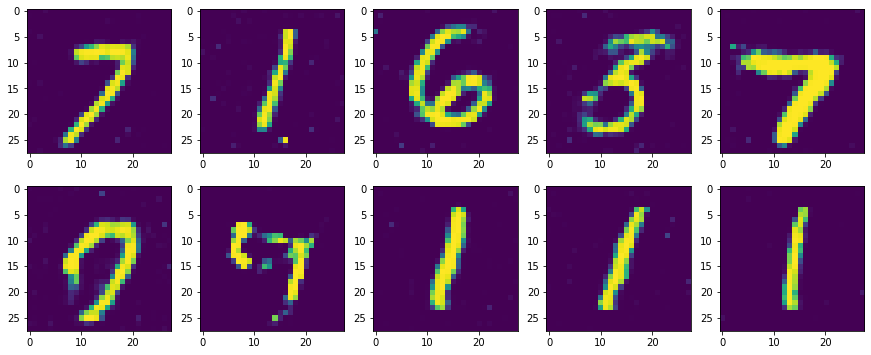

In [28]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

In [29]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.808897972106934, D:0.006919534876942635
[1/1 EPOCHS, 199 ITER] G:4.762513160705566, D:0.01745184324681759
[1/1 EPOCHS, 299 ITER] G:6.149504661560059, D:0.004610282368957996
[1/1 EPOCHS, 399 ITER] G:4.206735610961914, D:0.06002742052078247


In [31]:
!mkdir -p ~/aiffel/conditional_generation/cgan

In [32]:
!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip

--2021-10-18 13:47:54--  https://aiffelstaticprd.blob.core.windows.net/media/documents/CGAN_500.zip
Resolving aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)... 52.239.148.4
Connecting to aiffelstaticprd.blob.core.windows.net (aiffelstaticprd.blob.core.windows.net)|52.239.148.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2579076 (2.5M) [application/zip]
Saving to: ‘CGAN_500.zip’

CGAN_500.zip        100%[===================>]   2.46M  7.07MB/s    in 0.3s    

2021-10-18 13:47:55 (7.07 MB/s) - ‘CGAN_500.zip’ saved [2579076/2579076]



In [33]:
!mv CGAN_500.zip ~/aiffel/conditional_generation/cgan

In [34]:
!cd ~/aiffel/conditional_generation/cgan && unzip CGAN_500.zip

Archive:  CGAN_500.zip
  inflating: CGAN_500.index          
  inflating: CGAN_500.data-00001-of-00002  
  inflating: CGAN_500.data-00000-of-00002  


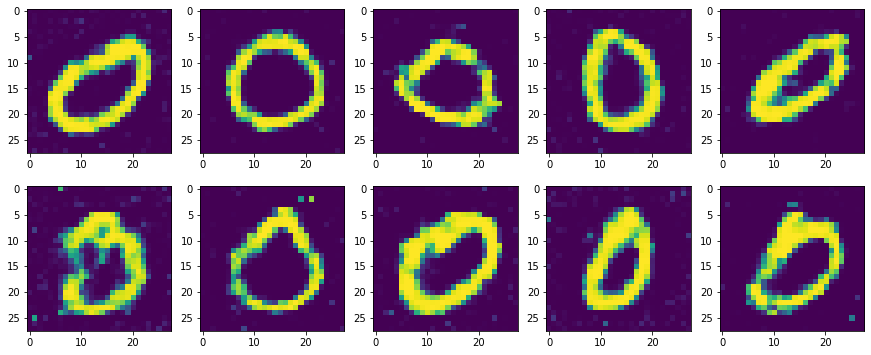

In [37]:
number = 0 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])